## 1. Objective

This notebook utilizes training and test data collected via '**collect_data.py**' to develop and evaluate the performance of a sequential neural network model for multiclass classification of specific poses based on body pose landmarks. The resulting model is intended for use in pose detection within the game "STRIKE A POSE!" (as implemented in '**play.py**').

## 2. Importing Modules 

In [1]:
import os # Operating system-related functions
import numpy as np # NumPy for numerical computations
import pandas as pd # for DataFrame
from PIL import Image # Image processing

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and deep learning libraries
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical # for one-hot encoding

2023-09-20 22:56:21.147641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3. Functions 

### 3.1 Functions for Preprocessing Training Data

In [2]:
# This function augments data by pertubing coordinates.
# It accepts a list of coordinates as input and introduces random translation and noise to each coordinate. The result is a set of perturbed coordinates returned as a NumPy array.

def perturbate_coordinates(coordinates, translation_range=0.05, noise_std=0.01):
    # Initialize an empty list to store perturbed coordinates.
    perturbed_coordinates = []
    
    # Loop through each coordinate in the input 'coordinates' list.
    for coord in coordinates:
        # Generate a random translation vector within the specified range
        translation = np.random.uniform(-translation_range, translation_range, size=2)
        
        # Translate the current coordinate by adding the random translation
        translated_coord = coord + translation
        
        # Generate random noise to add to the translated coordinate
        noise = np.random.normal(0, noise_std, size=2)
        
        # Add the noise to the translated coordinate to perturb it further
        perturbed_coord = translated_coord + noise
        
        # Append the perturbed coordinate to the list of perturbed_coordinates
        perturbed_coordinates.append(perturbed_coord)
        
     # Convert the list of perturbed coordinates into a NumPy array and return it
    return np.array(perturbed_coordinates)

In [3]:
# This function creates a label mapping dictionary based on the subfolders found within the 'landmarks_folder'.
# The resulting dictionary provides a convenient way to encode categorical labels as integers for further processing, such as one-hot encoding. 

def create_label_mapping(landmarks_folder):
    # Create a list of labels from subfolders (excluding '.DS_Store' if present)
    label_list = [label for label in os.listdir(landmarks_folder) if label != '.DS_Store']

    # Create a dictionary with integer labels (used for one-hot encoding)
    label_mapping = {}
    for code, label in enumerate(sorted(label_list)):
        label_mapping[label] = code

    return label_mapping

In [4]:
# This function loads and augments landmarks data.
# It takes a folder containing landmark coordinate data as input, along with optional parameters for augmentation.
# The function returns the augmented landmark coordinates as a NumPy array 'X' and their corresponding labels as a NumPy array 'y'.

def load_and_augment_landmarks(landmarks_folder, fold_expansion = 0, translation_range=0.05, noise_std=0.01):
    # Initialize empty lists to store data and labels
    X = []
    y = []
    
    # Loop through subfolders in the input 'landmarks_folder'
    for pose_folder in os.listdir(landmarks_folder):
        if not pose_folder.startswith('.'):  # Ignore hidden files
            pose_label = label_mapping.get(pose_folder)  # Use subfolder names as pose labels
            pose_folder_path = os.path.join(landmarks_folder, pose_folder) # Construct full path to the pose folder

            # Loop through files in the pose folder
            for file in os.listdir(pose_folder_path):
                if file.endswith('.npy'):  # Only check for '.npy' files
                    landmark_coordinates = np.load(os.path.join(pose_folder_path, file))  # Load landmark coordinates from file

                    # Append the original landmark coordinates and label to the data lists
                    X.append(landmark_coordinates)
                    y.append(pose_label)
                    
                    # Perform data augmentation 'fold_expansion' times with input parameters and append the pertubated landmark coordinates to data lists
                    for _ in range(fold_expansion):
                        perturbed_landmarks = perturbate_coordinates(landmark_coordinates, translation_range, noise_std)
                        X.append(perturbed_landmarks)
                        y.append(pose_label)

     # Convert data lists to NumPy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [5]:
"""
Function to flatten input data X before model training.
It takes a 3D numpy array 'X' representing landmark data, where 'num_samples' is the number of samples, 
'num_landmarks' is the number of landmarks in each sample, and 'num_dimensions' is the number of dimensions (2 for x and y coordinates).

It reshapes the input data by flattening the 'num_landmarks' and 'num_dimensions' dimensions into a single
dimension while preserving the 'num_samples' dimension. The resulting reshaped data has a shape of (num_samples, num_landmarks * num_dimensions).

Example:
If 'X' originally has a shape of (100, 10, 2), representing 100 samples, each with 10 landmarks in 2D space,
calling 'reshape_landmarks(X)' will return data with a shape of (100, 20), where each sample has been flattened
into a 1D array of 20 values.
"""

def reshape_landmarks(X):
    num_samples, num_landmarks, num_dimensions = X.shape
    X_reshaped = X.reshape(num_samples, num_landmarks * num_dimensions)
    
    return X_reshaped

### 3.2 Functions for Model Training

In [6]:
"""
Function that plots training and validation performance metrics (accuracy and loss) over epochs.

Args:
    - history (keras.callbacks.History): The history object obtained from training a Keras model.
    - save_plot (bool): Whether to save the plot to a file.
    - plot_filename (str): The filename/path to use when saving the plot.

Returns:
    - None (shows and saves (optional) plot).

Description:
    This function takes the training history of a Keras model as input and generates a plot to visualize the model's
    training and validation accuracy as well as training and validation loss over epochs. The input 'history' object
    typically contains metrics recorded during the training process.

    The function uses Seaborn and Matplotlib for plotting. It creates two y-axes, one for accuracy and another for loss,
    to better visualize these metrics together.

    If 'save_plot' is set to True and 'plot_filename' is provided, the plot is saved as an image file with the specified
    filename.

Example:
    To plot the training history of a model (e.g. 'history = model.fit(....)'), you can call this function with the 'history' object:
    plot_training_history(history)

    You can also save the plot to a file:
    plot_training_history(history, save_plot=True, plot_filename="model_performance.png")
    """

def plot_training_history(history, save_plot=False, plot_filename="Model_Performance.png"):
    
    # Extract training and validation metrics from the 'history' object
    train_accuracy = history.history['accuracy']
    train_loss = history.history['loss']
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Create a DataFrame to store metrics along with epochs
    epochs = range(1, len(train_accuracy) + 1)
    df_metrics = pd.DataFrame({'Epoch': epochs,
                               'Training Accuracy': train_accuracy,
                               'Validation Accuracy': val_accuracy,
                               'Training Loss': train_loss,
                               'Validation Loss': val_loss})

    # Create a figure for plotting
    plt.figure(figsize=(10, 5))

    # Plot accuracy on the first y-axis
    ax1 = sns.lineplot(x='Epoch', y='Training Accuracy', data=df_metrics, color='navy', label='Training Accuracy')
    ax1 = sns.lineplot(x='Epoch', y='Validation Accuracy', data=df_metrics, color='deepskyblue', label='Validation Accuracy')

    # Create a second y-axis for loss
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(x='Epoch', y='Training Loss', data=df_metrics, color='darkgreen', label='Training Loss', legend=False)
    ax2 = sns.lineplot(x='Epoch', y='Validation Loss', data=df_metrics, color='lightgreen', label='Validation Loss', legend=False)

    # Set labels for y-axes
    ax1.set_ylabel('Accuracy')
    ax2.set_ylabel('Loss')

    # Set legends for the lines plotted on each axis
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='center right')

    # Remove grid lines
    plt.grid(False)

    # Set plot title and labels
    plt.title('Training and Validation Accuracy & Loss')
    plt.xlabel('Epoch')
    
    # Optional: Save the plot to a file
    if save_plot and plot_filename:
        plt.savefig(plot_filename)

    # Display the plot
    plt.show()

### 3.3 Functions for Testing

In [7]:
"""
Load and preprocess test data from a specified folder for model prediction using the 'create_label_mapping' and 'reshape_landmarks' functions.

Args:
    - test_folder (str): The path to the folder containing test data (landmark coordinates).

Returns:
    - X_test (numpy.ndarray): An array of test data samples (flattened landmark coordinate data).
    - y_test (numpy.ndarray): An array of corresponding labels for the test data.
    - label_mapping as returned by function 'create_label_mapping'.

Note: This function assumes that the test data is stored in the following format (as generated by collect_data.py):
    - Each class/category has its own subfolder within the 'test_folder'.
    - Each subfolder contains '.npy' files, which are NumPy array files.
    - The 'create_label_mapping' function is used to create a mapping from class names to labels.
"""

def load_and_preprocess_test_data(test_folder):
    
    # Initialize empty lists to store test data and labels
    X_test = []
    y_test = []
    
    # Create a label mapping based on the subfolders of the 'test_folder'
    label_mapping = create_label_mapping(test_folder)  

    # Iterate through each subfolder (corresponding to a class) in 'test_folder'
    for label in os.listdir(test_folder):
        label_folder = os.path.join(test_folder, label)

        # Check if the item in 'test_folder' is a subfolder
        if os.path.isdir(label_folder):
            # Iterate through files in the subfolder
            for file_name in os.listdir(label_folder):
                 # Check if the file is a NumPy arrray
                if file_name.endswith('.npy'):
                    # Load  data from file
                    data = np.load(os.path.join(label_folder, file_name))
                    
                    # Append the data and its corresponding label to the lists
                    X_test.append(data)
                    y_test.append(label_mapping[label])
                    
    # Convert lists to NumPy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # Flatten the data so it can be used as input for model prediction.
    X_test_flattened = reshape_landmarks(X_test)
    
    return X_test_flattened, y_test, label_mapping

In [8]:
"""
Plot a confusion matrix to visualize model performance.

Args:
    - y_true (numpy.ndarray): The true class labels.
    - y_pred (numpy.ndarray): The predicted class labels.
    - label_mapping (dict): A dictionary mapping class names to class integers.
    - save_plot (bool, optional): Whether to save the plot as an image.
    - filename (str, optional): The filename to use when saving the plot.

Returns:
    - None (shows and saves (optional) plot).
    """
def plot_confusion_matrix(y_true, y_pred, label_mapping, save_plot=False, filename='confusion_matrix.png'):
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get class labels from the label_mapping dictionary
    class_labels = [label for label, idx in sorted(label_mapping.items(), key=lambda x: x[1])]

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels,
                annot_kws={'size': 16})  # Set font size for annotations
    plt.xticks(fontsize=20)  # Set font size for x-axis tick labels
    plt.yticks(fontsize=20)  # Set font size for y-axis tick labels
    plt.xlabel('Predicted', fontsize=20)  # Set font size for x-axis label
    plt.ylabel('Actual', fontsize=20)  # Set font size for y-axis label
    plt.title('Confusion Matrix / TEST', fontsize=20)  # Set font size for title
    
    # Save the plot if save_plot is True
    if save_plot:
        plt.savefig(filename)
    
    # Display the plot
    plt.show()

In [9]:
# Load images from a specified folder into a list

def load_images(image_folder):
    # Initialize an empty list to store loaded images
    image_list = []
    
    # Iterate through subfolders (= labels) in the image folder
    for label in os.listdir(image_folder):
        if not label.startswith('.'): # Ignore hidden files (e.g. macOS system files)
            image_label_folder = os.path.join(image_folder, label)
            
            # Iterate through image files in subfolder
            for image_file in os.listdir(image_label_folder):
                if image_file.endswith('.jpg'):
                    image = Image.open(os.path.join(image_label_folder, image_file))
                    image_list.append(image)

    return image_list

In [10]:
"""
Visualize prediction probabilities for a set of results.

Args:
    - y_actual (numpy.ndarray):  The true class labels for the results.
    - y_prediction (numpy.ndarray): Predicted probabilities for each class for each result.
    - image_folder (str): The folder containing images or data associated with the results (as generated by collect_data.py).
    - bar_1, bar_2, bar_3 (tuple, optional): Tuples representing vertical reference lines on the bar plot.
        - bar_x[0] (float): x-coordinate for the reference line.
        - bar_x[1] (str): Color of the reference line (e.g., 'red').
    - save_plot (bool, optional): Whether to save the plot as an image.
    - filename (str, optional): The filename to use when saving the plot.

Returns:
    - None (shows and saves (optional) plot).
"""

def visualize_prediction_probabilities(y_actual, y_prediction, image_folder, bar_1 = False, bar_2 = False, bar_3 = False, save_plot=False, filename='prediction_probs.png'):
    
    label_mapping = create_label_mapping(image_folder)

    # Determine the number of results
    num_results = y_prediction.shape[0]
    
    X_images = load_images(image_folder)

    # Set plot configuration parameters
    num_columns = 2  # Number of columns (1 for the bar plot, 1 for the image)
    subplot_width_ratio = 0.4  # Adjust this value to control the width of the bar plot side
    subplot_height = 3  # Adjust this value to control the height of each subplot
    num_rows = num_results

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * subplot_height),
                            gridspec_kw={'width_ratios': [subplot_width_ratio, 1 - subplot_width_ratio]})

    for i in range(num_results):
        ax_bar = axs[i, 0]
        ax_img = axs[i, 1]

        # Get class labels and predicted probabilities for the current result
        class_labels = list(label_mapping.keys())
        class_indices = list(label_mapping.values())
        predicted_probs = y_prediction[i]
        actual_label = class_labels[y_actual[i]]  # Get the actual label based on y_test

        # Plot bars for each class
        bars = ax_bar.barh(class_indices, predicted_probs, color='blue')

        # Set y-axis limits to always show 0 to 1 range
        ax_bar.set_xlim(0, 1)

        # Set y-axis labels and ticks
        ax_bar.set_yticks(class_indices)
        ax_bar.set_yticklabels(class_labels)

        # Set x-axis label
        ax_bar.set_xlabel('Predicted Probability')

        # Set bar plot title with actual label
        ax_bar.set_title(f"Result {i + 1} for $\mathbf{{{actual_label}}}$")
        
        if bar_1:
            ax_bar.axvline(x=bar_1[0], color=bar_1[1], linestyle='dotted', linewidth=3)
            
        if bar_2:
            ax_bar.axvline(x=bar_2[0], color=bar_2[1], linestyle='dotted', linewidth=3)
            
        if bar_3:
            ax_bar.axvline(x=bar_3[0], color=bar_3[1], linestyle='dotted', linewidth=3)

        # Display the image if available
        if X_images is not None:
            ax_img.imshow(X_images[i])
            ax_img.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()

    # Save the plot if save_plot is True
    if save_plot:
        plt.savefig(filename)

    # Display the plot
    plt.show()


## 4. Load and Preprocess Training Data

In [11]:
# Create label mapping dictionary

# Training data collected with collect_data.py
# Please note that in the repository, 'training_data' contains landmark data only, without annotated frames, to optimize data storage usage.
# When using custom training data, it is recommended to visually validate the recorded pose by referring to the corresponding recorded frames.

training_data = "training_data/landmarks/"

label_mapping = create_label_mapping(training_data)

label_mapping

{'X': 0, 'empty': 1, 'other': 2, 'squat': 3, 'stand': 4}

In [12]:
pose_names = [pose for pose in label_mapping.keys()]
pose_names

['X', 'empty', 'other', 'squat', 'stand']

In [13]:
# The original training data consists of coordinates for five classes: 'empty' (30), 'X' (30), 'squat' (30), 'stand' (31), and 'other' (80), totaling 201 data points.
# After augmentation (5-fold), the dataset now contains 1206 data points.

X, y = load_and_augment_landmarks(training_data, fold_expansion= 5, translation_range=0.05, noise_std=0.01)

X.shape, y.shape

((1206, 12, 2), (1206,))

In [14]:
# Split the data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((964, 12, 2), (242, 12, 2), (964,), (242,))

In [15]:
# Flatten the input data for training and validation sets

X_train_flattened = reshape_landmarks(X_train)
X_val_flattened = reshape_landmarks(X_val)

X_train_flattened.shape, X_val_flattened.shape

((964, 24), (242, 24))

In [16]:
# One-hot encode integer labels for training and validation sets
y_train_hot = to_categorical(y_train, num_classes=5)
y_val_hot = to_categorical(y_val, num_classes=5)

y_train_hot.shape, y_val_hot.shape

((964, 5), (242, 5))

## 4. Model Building

### 4.1 Train Model

In [17]:
# Create a sequential model
model = tf.keras.Sequential()

# Add layers to the model
model.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train_flattened.shape[1],)))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1600      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 3845 (15.02 KB)
Trainable params: 3845 (15.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Create an EarlyStopping callback to monitor validation accuracy and stop training if it doesn't improve for 10 consecutive epochs.

callback = EarlyStopping(monitor='val_accuracy', patience= 10, mode='max', min_delta=0.001, verbose=1)

In [19]:
# Train the model

batch_size = 32
epochs = 100

history = model.fit(X_train_flattened, y_train_hot, batch_size=batch_size, epochs=epochs, validation_data=(X_val_flattened, y_val_hot), callbacks=[callback])

Epoch 1/100
31/31 [==============================] - 1s 8ms/step - loss: 1.3968 - accuracy: 0.4336 - val_loss: 1.2308 - val_accuracy: 0.5579
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 1.2266 - accuracy: 0.5581 - val_loss: 1.1040 - val_accuracy: 0.5620
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 1.0729 - accuracy: 0.5892 - val_loss: 0.9320 - val_accuracy: 0.7066
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 0.9152 - accuracy: 0.6598 - val_loss: 0.7713 - val_accuracy: 0.7355
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 0.7656 - accuracy: 0.7210 - val_loss: 0.6416 - val_accuracy: 0.7645
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.7562 - val_loss: 0.5695 - val_accuracy: 0.8223
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 0.5859 - accuracy: 0.7718 - val_loss: 0.4885 - val_accuracy: 0.8306
Epoch 8/100
3

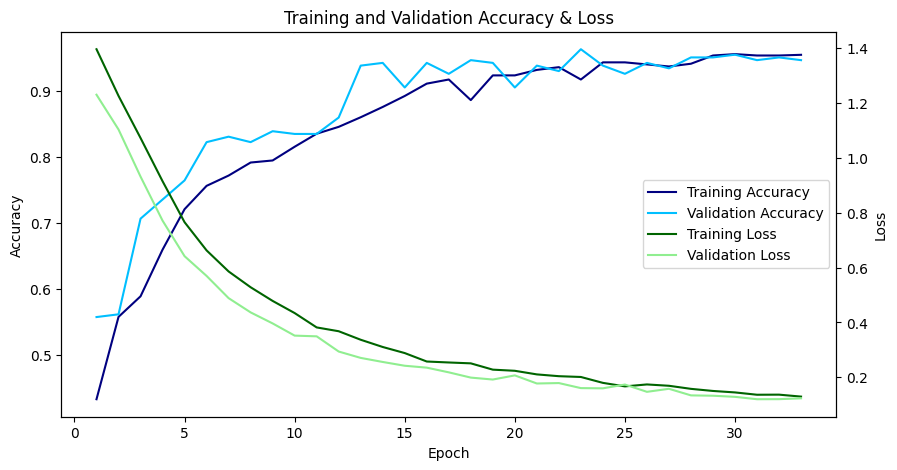

'\nDropout layers are introduced to:\n - Regularize; making classification of poses not too dependent on single/specific neurons.\n - Avoid overfitting.\n - Generalize; the model is more robust to variations in input data and reduces the influence of outliers.\n '

In [20]:
plot_training_history(history)

"""
Dropout layers are introduced to:
 - Regularize; making classification of poses not too dependent on single/specific neurons.
 - Avoid overfitting.
 - Generalize; the model is more robust to variations in input data and reduces the influence of outliers.
 """

### 4.2 Save Model

In [21]:
# Uncomment to save ;)

# model.save('model_pose_detection.h5')

## 5. Model testing

### 5.1 Load and Preprocess Test Data

In [22]:
# Load model (this is the one originally provided to play "STRIKE A POSE")

model = load_model("../model_strike_a_pose.h5")

In [23]:
# Load test data
# Note: Due to time constraints, training data was only collected by recording one individual. 
# To demonstrate the model's ability to confidently classify poses by others, testing data was collected by recording poses performed by a different person (using collect_data.py).

# Test data consists of recorded coordinates for five classes: 'X' (13), 'squat' (13), 'stand' (11), 'empty' (12), and 'other' (13), totaling 62 data points.
# Note: The 'other' class exclusively contains 'crane' pose recordings, a challenging pose to classify and distinguish from 'stand' and 'X'. Visualizations of this pose can be found in the 'frames' folder.
# (Visualizations of this pose can be found in the 'frames' folder).

test_landmarks = "test_data/landmarks"

X_test, y_test, label_mapping = load_and_preprocess_test_data(test_landmarks)

X_test.shape, y_test.shape, label_mapping

((62, 24), (62,), {'X': 0, 'empty': 1, 'other': 2, 'squat': 3, 'stand': 4})

### 5.2 Perfom Test Prediction

In [24]:
# Predict poses using the model

y_pred = model.predict(X_test) # 'y_pred' contains the raw prediction scores for each class for each test sample.
y_pred_classes = np.argmax(y_pred, axis=1) # Convert the raw prediction scores into predicted class labels by selecting the class with the highest score for each test sample.

2/2 [==============================] - 0s 3ms/step


### 5.3 Analyze Test Predictions

#### 5.3.1 Confusion Matrix

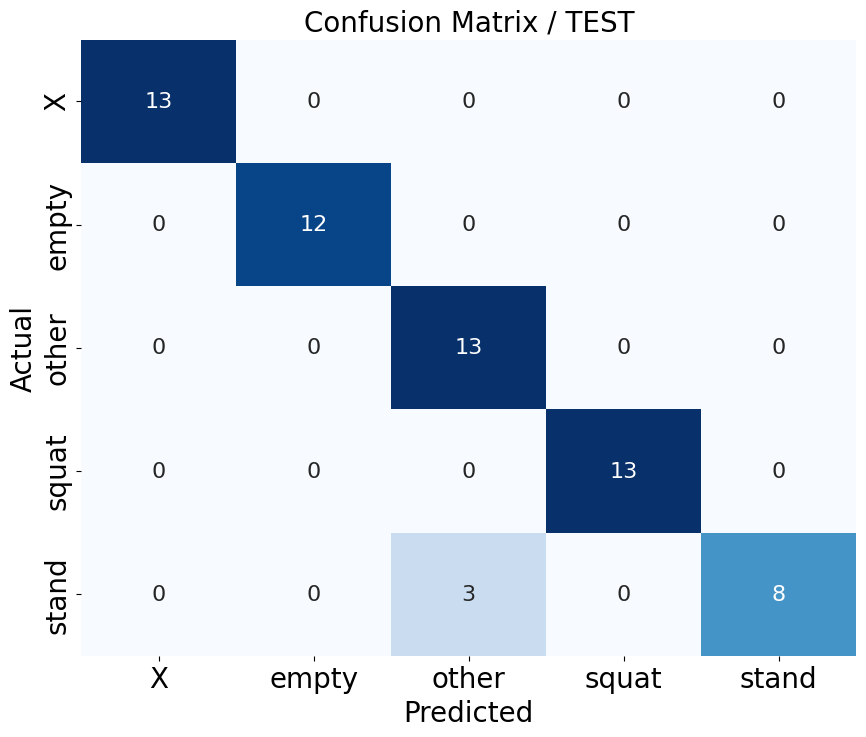

In [25]:
# Plot Confusion Matrix

plot_confusion_matrix(y_test, y_pred_classes, label_mapping)

# The model performs well in predicting most poses but exhibits limitations in correctly classifying 'stand'.
# Further analysis is conducted below by exploring prediction probabilities.

#### 5.3.2 Prediction Probabilities 

In [26]:
image_folder = 'test_data/frames'

In [ ]:
visualize_prediction_probabilities(y_test ,y_pred, image_folder, bar_1 = (0.7, "red"), bar_2 = (0.5, "green"), bar_3 = (0.2, "green"))
                                                                                                                                       
"""   
'Pose' is used as a wildcard to represent any pose except for the specific ones: 'Hide,' 'X,' 'Squat,' or 'Stand.'

Some 'Stand' poses have been miscategorized as 'Pose'/other category: Result 43, 47, 48 (also see confusion matrix above).

Certain 'Stand' poses are classified with low confidence, where the prediction probability is < 0.7: Results 42, 44, 46.

Despite variations in the model's prediction performance for the 'Stand' pose, a visual examination of the pose coordinates does not reveal any discernible differences that could account for this behavior.
It's worth noting that the 'Pose'/other category is somehow linked to the 'Stand' pose based on the model's classification.

To address the classifier's unique behavior in these situations, the following set of rules is established to guide the final classification process (constants used in 'predict_pose' functions in utils.py):

Constants used in 'predict_pose' functions (see utils.py).

CONFIDENCE_THRESHOLD = 0.7  -- min. prediction confidence to be reached (but for 'Stand'), otherwise reclassified to 'Pose'.
CONFIDENCE_THRESHOLD_STAND = 0.5  -- min. prediction confidence to be reached for 'Stand', otherwise reclassified to 'Pose'.
CONFIDENCE_THRESHOLD_POSE_TO_STAND = 0.2  -- min. prediction confidence classification 'Stand' if 'Pose' is the most likel prediction with 'Stand' being the second most likely.

These rules and thresholds are implemented to fine-tune the model's behavior and mitigate misclassifications, particularly when distinguishing 'Stand' from 'Pose'.
"""